In [ ]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse

from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass

!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 144379 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.22-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.22-0ubuntu1~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.22-0ubuntu1~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope

In [61]:
from keras.applications import vgg16
from keras.preprocessing.image import load_img,img_to_array
from keras.models import Model
from keras.applications.imagenet_utils import preprocess_input

from PIL import Image
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

In [62]:
vgg_model = vgg16.VGG16(weights='imagenet')

In [63]:
imgs_path = "/content/drive/DeepLearning-Krish/Recommender/input/style/"
img_width, img_height = 224, 224

nb_closest_images = 5

In [64]:
#removing last layer
extractor = Model(input=vgg_model.input,output=vgg_model.get_layer("fc2").output)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("fc...)`
  


In [65]:
extractor.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [66]:
files = [imgs_path + x for x in os.listdir(imgs_path) if "png" in x]

In [67]:
print(f'Number of Images = {len(files)}')

Number of Images = 2184


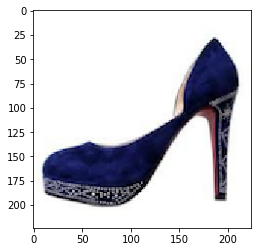

In [68]:
original = load_img(files[2],target_size=(img_width,img_height))
plt.imshow(original)
plt.show()


In [69]:
numpy_image = img_to_array(original)
image_exp = np.expand_dims(numpy_image,axis=0)

process_img = preprocess_input(image_exp.copy())

In [70]:
print(image_exp.shape)

(1, 224, 224, 3)


In [71]:
img_features = extractor.predict(process_img)

In [72]:

print("number of image features:",img_features.size)

number of image features: 4096


In [73]:
img_features

array([[0.       , 1.1710858, 0.       , ..., 0.       , 0.       ,
        0.       ]], dtype=float32)

In [74]:
ImportedImages = []

for f  in files:
    filename = f
    original = load_img(filename,target_size=(224,224))
    numpy_image = img_to_array(original)
    image_exp = np.expand_dims(numpy_image,axis=0)

    ImportedImages.append(image_exp)

In [75]:
images = np.vstack(ImportedImages)
proceessed_images = preprocess_input(images.copy())

In [77]:
img_features = extractor.predict(proceessed_images)

In [78]:
img_features.shape

(2184, 4096)

In [80]:
cosSimilarities = cosine_similarity(img_features)



In [81]:
cos_similarities_df = pd.DataFrame(cosSimilarities, columns=files, index=files)
cos_similarities_df.head()

,/content/drive/DeepLearning-Krish/Recommender/input/style/1_9_024.png,/content/drive/DeepLearning-Krish/Recommender/input/style/3_2_049.png,/content/drive/DeepLearning-Krish/Recommender/input/style/0_0_029.png,/content/drive/DeepLearning-Krish/Recommender/input/style/5_4_003.png,/content/drive/DeepLearning-Krish/Recommender/input/style/2_4_016.png,/content/drive/DeepLearning-Krish/Recommender/input/style/0_2_018.png,/content/drive/DeepLearning-Krish/Recommender/input/style/0_2_023.png,/content/drive/DeepLearning-Krish/Recommender/input/style/4_1_030.png,/content/drive/DeepLearning-Krish/Recommender/input/style/4_5_014.png,/content/drive/DeepLearning-Krish/Recommender/input/style/4_6_028.png,/content/drive/DeepLearning-Krish/Recommender/input/style/1_8_008.png,/content/drive/DeepLearning-Krish/Recommender/input/style/3_2_055.png,/content/drive/DeepLearning-Krish/Recommender/input/style/6_3_023.png,/content/drive/DeepLearning-Krish/Recommender/input/style/2_9_004.png,/content/drive/DeepLearning-Krish/Recommender/input/style/4_6_004.png,/content/drive/DeepLearning-Krish/Recommender/input/style/3_0_029.png,/content/drive/DeepLearning-Krish/Recommender/input/style/6_9_019.png,/content/drive/DeepLearning-Krish/Recommender/input/style/5_9_012.png,/content/drive/DeepLearning-Krish/Recommender/input/style/2_2_024.png,/content/drive/DeepLearning-Krish/Recommender/input/style/4_4_022.png,/content/drive/DeepLearning-Krish/Recommender/input/style/2_0_011.png,/content/drive/DeepLearning-Krish/Recommender/input/style/1_1_004.png,/content/drive/DeepLearning-Krish/Recommender/input/style/1_9_006.png,/content/drive/DeepLearning-Krish/Recommender/input/style/4_1_045.png,/content/drive/DeepLearning-Krish/Recommender/input/style/1_7_013.png,/content/drive/DeepLearning-Krish/Recommender/input/style/6_0_032.png,/content/drive/DeepLearning-Krish/Recommender/input/style/3_9_015.png,/content/drive/DeepLearning-Krish/Recommender/input/style/2_2_061.png,/content/drive/DeepLearning-Krish/Recommender/input/style/2_2_037.png,/content/drive/DeepLearning-Krish/Recommender/input/style/3_0_021.png,/content/drive/DeepLearning-Krish/Recommender/input/style/4_8_001.png,/content/drive/DeepLearning-Krish/Recommender/input/style/2_4_013.png,/content/drive/DeepLearning-Krish/Recommender/input/style/2_2_068.png,/content/drive/DeepLearning-Krish/Recommender/input/style/4_3_031.png,/content/drive/DeepLearning-Krish/Recommender/input/style/0_0_024.png,/content/drive/DeepLearning-Krish/Recommender/input/style/1_6_011.png,/content/drive/DeepLearning-Krish/Recommender/input/style/1_0_009.png,/content/drive/DeepLearning-Krish/Recommender/input/style/1_1_001.png,/content/drive/DeepLearning-Krish/Recommender/input/style/4_4_020.png,/content/drive/DeepLearning-Krish/Recommender/input/style/3_0_074.png,...,/content/drive/DeepLearning-Krish/Recommender/input/style/1_1_005.png,/content/drive/DeepLearning-Krish/Recommender/input/style/4_2_055.png,/content/drive/DeepLearning-Krish/Recommender/input/style/3_0_068.png,/content/drive/DeepLearning-Krish/Recommender/input/style/4_6_037.png,/content/drive/DeepLearning-Krish/Recommender/input/style/2_1_029.png,/content/drive/DeepLearning-Krish/Recommender/input/style/0_3_027.png,/content/drive/DeepLearning-Krish/Recommender/input/style/4_4_032.png,/content/drive/DeepLearning-Krish/Recommender/input/style/6_8_024.png,/content/drive/DeepLearning-Krish/Recommender/input/style/5_7_001.png,/content/drive/DeepLearning-Krish/Recommender/input/style/6_8_018.png,/content/drive/DeepLearning-Krish/Recommender/input/style/4_5_008.png,/content/drive/DeepLearning-Krish/Recommender/input/style/6_2_013.png,/content/drive/DeepLearning-Krish/Recommender/input/style/3_2_062.png,/content/drive/DeepLearning-Krish/Recommender/input/style/0_2_028.png,/content/drive/DeepLearning-Krish/Recommender/input/style/3_1_001.png,/content/drive/DeepLearning-Krish/Recommender/input/style/3_2_005.png,/content/drive/DeepLearning-Krish/Recommender/input/style/3_9_019.png,/cont

In [86]:
def retrive_similar(given_img):
  print('------------------------------------------------------------------------------------')
  print("ORIGINAL")
  original = load_img(given_img,target_size=(img_width,img_height))
  plt.imshow(original)
  plt.show()

  print('------------------------------------------------------------------------------------')
  print('SIMILAR  PICS')
  close_img = cos_similarities_df[given_img].sort_values(ascending=False)[1:nb_closest_images].index
  close_score = cos_similarities_df[given_img].sort_values(ascending=False)[1:nb_closest_images]

  for i in range(0,len(close_img)):
    original = load_img(close_img[i],target_size=(img_width,img_height))
    plt.imshow(original)
    plt.show()
    print(f'SIMILARITY {close_img[i]}')

------------------------------------------------------------------------------------
ORIGINAL


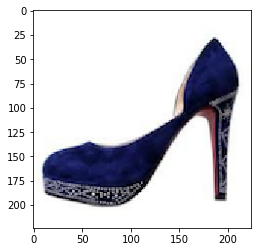

------------------------------------------------------------------------------------
SIMILAR  PICS


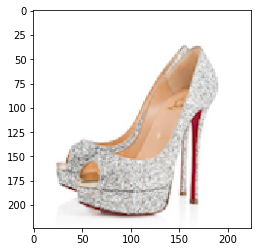

SIMILARITY /content/drive/DeepLearning-Krish/Recommender/input/style/0_0_036.png


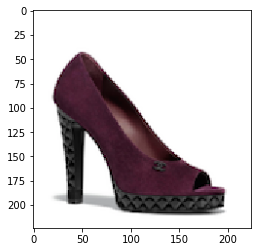

SIMILARITY /content/drive/DeepLearning-Krish/Recommender/input/style/1_0_029.png


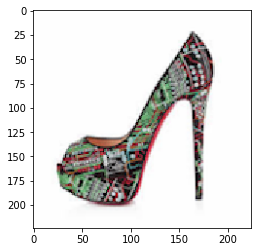

SIMILARITY /content/drive/DeepLearning-Krish/Recommender/input/style/0_0_054.png


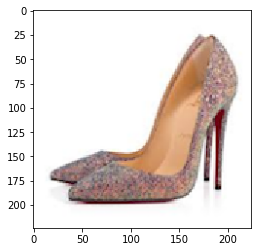

SIMILARITY /content/drive/DeepLearning-Krish/Recommender/input/style/0_0_044.png


In [90]:
retrive_similar(files[2])